# Consumer Expenditure Survey

Brian Dew

@bd_econ

In [1]:
%config Completer.use_jedi = False
import sys
sys.path.append('../src')

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

In [2]:
# Fred series - Median personal income
series_id = 'MEPAINUSA646N'
medinc = fred_df(series=series_id, start='1984')
medinc.to_csv(data_dir / 'median_pi.csv', index_label='date')

<AxesSubplot:xlabel='DATE'>

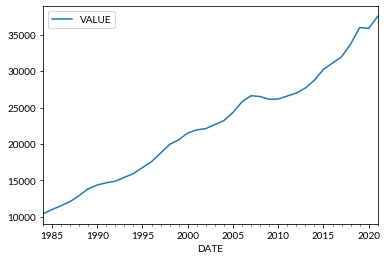

In [4]:
medinc.plot()

In [2]:
# Fred series - Median personal income
series_id = 'MEPAINUSA646N'
medinc = fred_df(series=series_id, start='1984')
medinc.to_csv(data_dir / 'median_pi.csv', index_label='date')

url = 'https://download.bls.gov/pub/time.series/cx/cx.data.1.AllData'
df = pd.read_table(url, sep='\s+', dtype='object')
full = df.set_index('series_id').drop(['footnote_codes', 'period'], 
                                      axis=1)
full.to_csv(data_dir / 'ce_full.csv')

In [2]:
medinc = pd.read_csv(data_dir / 'median_pi.csv', index_col='date', 
                     parse_dates=True)
medinc.index = medinc.index.year

df = pd.read_csv(data_dir / 'ce_full.csv')
yr = f"{df['year'].iloc[-1]}"
write_txt(text_dir / 'ce_year.txt', yr)
cats = ['TOTALEXP', 'INCAFTTX', 'INCBEFTX', 'PENSIONS', 'CHGASLI', 
        '900000', 'SFEMPINC', 'INDIVRNT', '980010']

grps = [1, 2, 3, 4, 5, 6]

results = pd.DataFrame()
for grp in grps:
    for cat in cats:
        if cat != '980010':
            datatype = 'int'
        else: 
            datatype = 'float'
        srs = f'CXU{cat}LB010{grp}M'
        data = (df.loc[df.series_id == srs]
                  .set_index('year')['value']
                  .astype(datatype))
        name = f'{cat}_{grp}'
        results[name] = data
        
    exp = (results[f'TOTALEXP_{grp}'] - results[f'PENSIONS_{grp}'])
    results[f'ADJEXP_{grp}'] = exp
    di_save = results[f'INCAFTTX_{grp}'] - exp
    mi = (results[f'900000_{grp}'] + results[f'SFEMPINC_{grp}']
          + results[f'INDIVRNT_{grp}'])
    mi_save = mi - exp                                   
    results[f'DI_SAVE_RT_{grp}'] = (di_save.to_numpy() / 
                                    medinc.VALUE.to_numpy()) * 100
    results[f'MI_SAVE_RT_{grp}'] = (mi_save.to_numpy() / 
                                    medinc.VALUE.to_numpy()) * 100
    results[f'DI_SAVE_{grp}'] = di_save
    results[f'MI_SAVE_{grp}'] = mi_save
    
results.index = [pd.to_datetime(f'{dt}-01-01') for dt in results.index]
results.loc['1988':].to_csv(data_dir / 'ce_table.csv', index_label='date')
color = {'DI_SAVE_RT_2': 'violet', 'DI_SAVE_RT_3': 'red!20!orange!95!black',
         'DI_SAVE_RT_4': 'green!80!blue!85!black', 
         'DI_SAVE_RT_5': 'red!80!black',
         'DI_SAVE_RT_6': 'blue!80!cyan!80!black'}
results.loc['1989':, color.keys()].to_csv(data_dir / 'save_dist.csv', 
                                     index_label='date')

nmax = {i: None for i in color.keys()}
maxsrs = results[color.keys()].iloc[-1].idxmax()
nmax[maxsrs] = 'y'

nodes = '\n'.join([end_node(results[i], color[i], percent=True, 
                            date=nmax[i], full_year=True) 
                   for i in color.keys()])
write_txt(text_dir / 'save_dist_nodes.txt', nodes)

ltyr = results.index[-1].year
b20 = results['DI_SAVE_RT_2'].iloc[-1]
t20 = results['DI_SAVE_RT_6'].iloc[-1]
m20 = results['DI_SAVE_RT_4'].iloc[-1]
lm20vpr = results['DI_SAVE_RT_3'].iloc[-2]
lm20v = results['DI_SAVE_RT_3'].iloc[-1]
lm20_1 = (f'saved the equivalent of {abs(lm20v):.1f} percent of '+
          f'a median income in {ltyr}')
lm20_2 = (f'did not save in {ltyr}, but dissaved less '+
          'than previous years ')
lm20_3 = (f'dissaved the equivalent of {abs(lm20v):.1f} percent '+
          f'of a median income in {ltyr}')
lm20 = lm20_1 if lm20v > 0 else lm20_2 if lm20v > lm20vpr else lm20_3
text = ('The 20 percent of households with the least income '+
        f'dissave the equivalent of {abs(b20):.1f} percent of the '+
        f'US median personal income in {ltyr} '+
        f'{c_line(color["DI_SAVE_RT_2"])}. This group includes '+
        'people going into debt and retirees dissaving. In '+
        'the same period, the top 20 percent of households '+
        f'save the equivalent of {t20:.1f} percent of the '+
        f'median income {c_line(color["DI_SAVE_RT_6"])}.\n\n '+
        'The middle fifth of households by income, percentiles '+
        f'40--60, saved the equivalent of {m20:.1f} percent of '+
        f'the median income {c_line(color["DI_SAVE_RT_4"])}. '+
        'The fifth of households below the middle group, in '+
        f'percentiles 20--40, {lm20} {c_line(color["DI_SAVE_RT_3"])}.')
write_txt(text_dir / 'save_dist.txt', text)
print(text)

The 20 percent of households with the least income dissave the equivalent of 38.8 percent of the US median personal income in 2021 (see {\color{violet}\textbf{---}}). This group includes people going into debt and retirees dissaving. In the same period, the top 20 percent of households save the equivalent of 206.8 percent of the median income (see {\color{blue!80!cyan!80!black}\textbf{---}}).

 The middle fifth of households by income, percentiles 40--60, saved the equivalent of 25.9 percent of the median income (see {\color{green!80!blue!85!black}\textbf{---}}). The fifth of households below the middle group, in percentiles 20--40, dissaved the equivalent of 12.1 percent of a median income in 2021 (see {\color{red!20!orange!95!black}\textbf{---}}).


### Overview for median

In [4]:
# Overview for median income, spending, saving
pce = pd.read_csv(data_dir / 'nipa20804.csv', 
                  index_col='date', parse_dates=True)['DPCERG']
pce_ann = (pce.iloc[-1] / pce).resample('AS').mean()

cols = ['INCAFTTX_4', 'ADJEXP_4', 'DI_SAVE_4', '980010_4']
ce_table = pd.read_csv(data_dir / 'ce_table.csv', index_col=0, 
                       parse_dates=True)
res = (ce_table[cols[:3]].divide(ce_table[cols[3]],axis=0)
       .multiply(pce_ann, axis=0) / 1000)
res.dropna().to_csv(data_dir / 'medincexp.csv', index_label='date')

In [5]:
incval = res.loc[res.dropna().index[-1], 'INCAFTTX_4']
incval = f'\${incval * 1000:,.0f}'
expval = res.loc[res.dropna().index[-1], 'ADJEXP_4']
expval = f'\${expval * 1000:,.0f}'
saveval = res.loc[res.dropna().index[-1], 'DI_SAVE_4']
saveval = f'\${saveval * 1000:,.0f}'
ltyear = res.dropna().index[-1].year

colors = {'inc': 'blue!50!cyan', 'exp': 'red!50!orange', 
          'save': 'green!50!blue'}

text = (f'In {ltyear}, after-tax income is {incval} per person '+
        f'for the middle fifth of households {c_line(colors["inc"])}. '+
        f'Spending for these households is {expval} per person '+
        f'{c_line(colors["exp"])}, and saving is {saveval} per person '+
        f'{c_line(colors["save"])}.')
write_txt(text_dir / 'ce_med_inc.txt', text)
print(text)

In 2021, after-tax income is \$25,992 per person for the middle fifth of households (see {\color{blue!50!cyan}\textbf{---}}). Spending for these households is \$21,852 per person (see {\color{red!50!orange}\textbf{---}}), and saving is \$4,140 per person (see {\color{green!50!blue}\textbf{---}}).


### Income and Spending by Age Group

In [6]:
cats = {'TOTALEXP': 'Spending', 'INCAFTTX': 'After-tax income',
        'INCBEFTX': 'Pre-tax income', 'PENSIONS':'Pension spending'}

grps = {2: 'Under 25', 3: '25-34', 4: '35-44', 
        5: '45-54', 6: '55-64', 8: '65-74', 9: '75+'}

results = pd.DataFrame()
for grp, name in grps.items():
    for cat, cname in cats.items():
        srs = f'CXU{cat}LB040{grp}M'
        yr = data.index[-1]
        data = (df.loc[df.series_id == srs]
                  .set_index('year')['value'])
        val = data.loc[yr]
        results.loc[name, cname] = int(val)
        
exp = (results['Spending'] - results['Pension spending'])
results.loc[:, 'Adjusted spending'] = exp
cols = ['After-tax income', 'Adjusted spending']
results[cols].divide(1000).to_csv(data_dir / 'ce_age.csv', index_label='name')

year = data.index[-1]

write_txt(text_dir / 'ce_year.txt', str(year))

grp_names = {'Under 25': 'youngest age group', '25-34': '25--34 age group',
             '35-44': '35--44 age group', '45-54': '45--54 age group',
             '55-64': '55--64 age group', '75+': 'oldest age group'}

inc_max_grp = grp_names[results['After-tax income'].idxmax()]
inc_min_grp = grp_names[results['After-tax income'].idxmin()]
exp_max_grp = grp_names[results['Adjusted spending'].idxmax()]
exp_min_grp = grp_names[results['Adjusted spending'].idxmin()]

inc_max_val = f"\${results['After-tax income'].max().round(-2):,.0f}"
inc_min_val = f"\${results['After-tax income'].min().round(-2):,.0f}"
exp_max_val = f"\${results['Adjusted spending'].max().round(-2):,.0f}"
exp_min_val = f"\${results['Adjusted spending'].min().round(-2):,.0f}"

text = (f'In {year}, after-tax household income '+
        '(see\cbox{green!80!blue}) ranges from '+
        f'{inc_min_val} for the {inc_min_grp} to '+
        f'{inc_max_val} for the {inc_max_grp}. '+
        'Spending, excluding pensions, (see\cbox{blue!40!magenta}) '+
        f'ranges from {exp_min_val} for the {exp_min_grp} '+
        f'to {exp_max_val} for the {exp_max_grp}.')
write_txt(text_dir / 'ce_age.txt', text)
print(text)

In 2021, after-tax household income (see\cbox{green!80!blue}) ranges from \$43,200 for the oldest age group to \$103,500 for the 45--54 age group. Spending, excluding pensions, (see\cbox{blue!40!magenta}) ranges from \$38,100 for the youngest age group to \$72,800 for the 45--54 age group.


### Distribution by Income

In [7]:
cats = {'TOTALEXP': 'Spending', 'INCAFTTX': 'After-tax income',
        'INCBEFTX': 'Pre-tax income', 'PENSIONS':'Pension spending'}

grps = {'0102': 'Bottom 20 Percent', '0103': 'Percentile 20--40',
        '0104': 'Percentile 40--60', '0105': 'Percentile 60--80',
        '1510': 'Percentile 80--90', '1511': 'Top 10 Percent'}

results = pd.DataFrame()
for grp, name in grps.items():
    for cat, cname in cats.items():
        srs = f'CXU{cat}LB{grp}M'
        yr = int(data.index[-1])
        data = (df.loc[df.series_id == srs]
                  .set_index('year')['value'])
        val = data.loc[yr]
        results.loc[name, cname] = int(val)
        
exp = (results['Spending'] - results['Pension spending'])
results.loc[:, 'Adjusted spending'] = exp
cols = ['After-tax income', 'Adjusted spending']
results[cols].divide(1000).to_csv(data_dir / 'ce_inc.csv', index_label='name')

In [8]:
inc_max_grp = results['After-tax income'].idxmax().lower()
inc_min_grp = results['After-tax income'].idxmin().lower()
exp_max_grp = results['Adjusted spending'].idxmax().lower()
exp_min_grp = results['Adjusted spending'].idxmin().lower()

inc_max_val = f"\${results['After-tax income'].max().round(-2):,.0f}"
inc_min_val = f"\${results['After-tax income'].min().round(-2):,.0f}"
exp_max_val = f"\${results['Adjusted spending'].max().round(-2):,.0f}"
exp_min_val = f"\${results['Adjusted spending'].min().round(-2):,.0f}"

text = (f'In {year}, after-tax household income '+
        '(see\cbox{blue!70!black}) ranges from '+
        f'{inc_min_val} for the {inc_min_grp} to '+
        f'{inc_max_val} for the {inc_max_grp}. '+
        'Spending, excluding pensions, (see\cbox{blue!30!cyan}) '+
        f'ranges from {exp_min_val} for the {exp_min_grp} by income, '+
        f'to {exp_max_val} for the {exp_max_grp} income group.')
write_txt(text_dir / 'ce_inc_pct.txt', text)
print(text)

In 2021, after-tax household income (see\cbox{blue!70!black}) ranges from \$15,900 for the bottom 20 percent to \$233,600 for the top 10 percent. Spending, excluding pensions, (see\cbox{blue!30!cyan}) ranges from \$30,500 for the bottom 20 percent by income, to \$128,400 for the top 10 percent income group.
